In [ ]:
#GOOGLENET, RESNET AND ENSEMBLE LEARNING:
#Training Accuracy, Training Loss, Testing Accuracy, Testing Loss and Plots


In [ ]:
!pip install -q kaggle torchvision scikit-learn matplotlib seaborn

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.15G/5.20G [01:45<00:03, 16.3MB/s]
100% 5.20G/5.20G [01:46<00:00, 52.7MB/s]


In [ ]:
# Merge image folders
os.makedirs("HAM10000_images", exist_ok=True)
for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), os.path.join("HAM10000_images", file))

# Load metadata
df = pd.read_csv("HAM10000_metadata.csv")
df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bkl', 'bcc', 'akiec'] else 0)


In [ ]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

def get_loaders(batch_size):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size)
    )


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# ====== Model Definition ======
def get_model(model_name='resnet', dropout=0.3):
    if model_name == 'resnet':
        from torchvision.models import resnet18
        model = resnet18(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(model.fc.in_features, 1)
        )
    elif model_name == 'googlenet':
        from torchvision.models import googlenet
        # aux_logits must be True if pretrained=True
        model = googlenet(pretrained=True, aux_logits=True)
        model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(model.fc.in_features, 1)
        )
        # Optional: you can ignore aux_logits output during training
        model.aux_logits = False  # Prevents using aux output in loss calculation
    else:
        raise ValueError("Invalid model name")
    return model

# ====== Training Loop ======
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_auc': []
    }

    best_auc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = train_loss / total
        epoch_train_acc = correct / total

        # ===== Validation =====
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()

                val_preds.extend(probs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        epoch_val_auc = roc_auc_score(val_labels, val_preds)

        if epoch_val_auc > best_auc:
            best_auc = epoch_val_auc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), "best_model.pth")

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}, AUC: {epoch_val_auc:.4f}")

    model.load_state_dict(best_model_wts)
    return history

# ====== Plotting Function ======
def plot_train_metrics(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name.upper()} - Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name.upper()} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ====== Testing Function ======
def evaluate_on_test(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_probs = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).float()

            y_probs.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    auc = roc_auc_score(y_true, y_probs)

    return acc, auc, avg_loss


/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/5 | Train Loss: 0.3524, Acc: 0.8422 | Val Loss: 0.2754, Acc: 0.8831, AUC: 0.9435
Epoch 2/5 | Train Loss: 0.2137, Acc: 0.9156 | Val Loss: 0.2790, Acc: 0.8731, AUC: 0.9507
Epoch 3/5 | Train Loss: 0.1014, Acc: 0.9638 | Val Loss: 0.3280, Acc: 0.8781, AUC: 0.9381
Epoch 4/5 | Train Loss: 0.0622, Acc: 0.9784 | Val Loss: 0.3139, Acc: 0.8801, AUC: 0.9537
Epoch 5/5 | Train Loss: 0.0480, Acc: 0.9832 | Val Loss: 0.3626, Acc: 0.8891, AUC: 0.9439


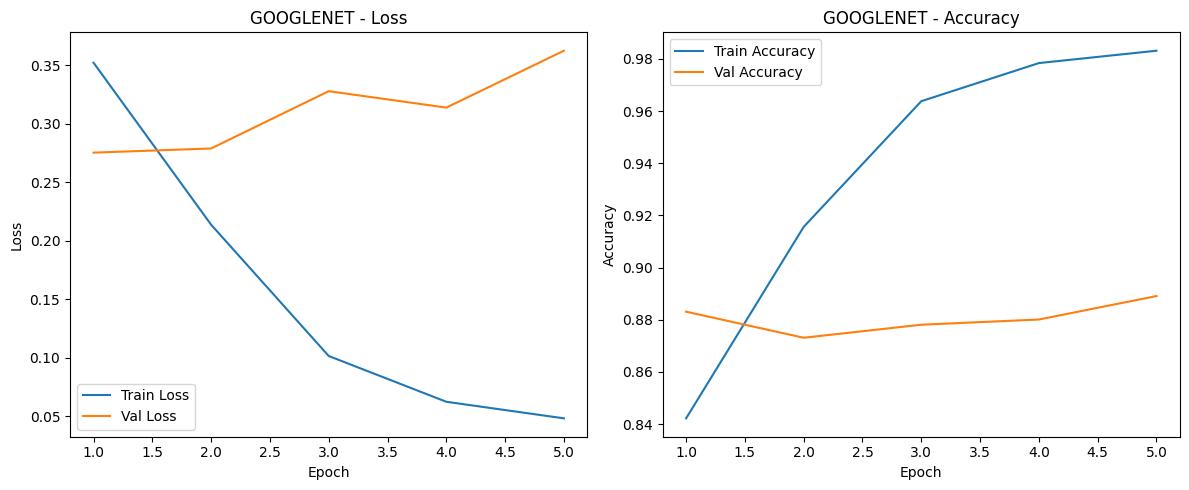


====== FINAL METRICS ======
Training Accuracy: 0.9832
Training Loss:     0.0480
Testing Accuracy:  0.8872
Testing Loss:      0.3120


In [ ]:
# ==== Hyperparameters ====
model_name = 'googlenet'  # or 'resnet'
dropout = 0.3
lr = 1e-4
batch_size = 32
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==== Load Data ====
train_loader, val_loader, test_loader = get_loaders(batch_size)  # <-- Replace with your function

# ==== Initialize Model ====
model = get_model(model_name, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# ==== Train ====
history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device)

# ==== Plot ====
plot_train_metrics(history, model_name)

# ==== Final Training Metrics ====
final_train_acc = history['train_acc'][-1]
final_train_loss = history['train_loss'][-1]

# ==== Test Evaluation ====
model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc, test_loss = evaluate_on_test(model, test_loader, device=device)

# ==== Final Metrics Output ====
print("\n====== FINAL METRICS ======")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Training Loss:     {final_train_loss:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Testing Loss:      {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


Epoch 1/5 | Train Loss: 0.3440, Acc: 0.8470 | Val Loss: 0.2833, Acc: 0.8861, AUC: 0.9408
Epoch 2/5 | Train Loss: 0.1920, Acc: 0.9225 | Val Loss: 0.2686, Acc: 0.8891, AUC: 0.9501
Epoch 3/5 | Train Loss: 0.1055, Acc: 0.9588 | Val Loss: 0.2758, Acc: 0.8981, AUC: 0.9546
Epoch 4/5 | Train Loss: 0.0666, Acc: 0.9750 | Val Loss: 0.3183, Acc: 0.8921, AUC: 0.9481
Epoch 5/5 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.3130, Acc: 0.8971, AUC: 0.9559


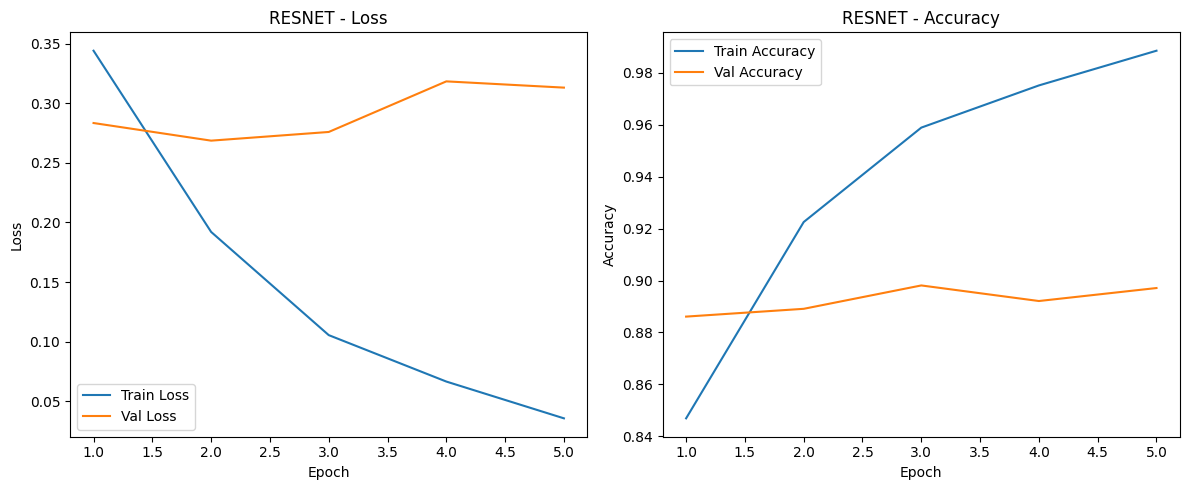


====== FINAL METRICS ======
Training Accuracy: 0.9884
Training Loss:     0.0357
Testing Accuracy:  0.9152
Testing Loss:      0.2516


In [ ]:
# ==== Hyperparameters ====
model_name = 'resnet'
dropout = 0.3
lr = 1e-4
batch_size = 32
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==== Load Data ====
train_loader, val_loader, test_loader = get_loaders(batch_size)  # <-- Replace with your function

# ==== Initialize Model ====
model = get_model(model_name, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# ==== Train ====
history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs, device)

# ==== Plot ====
plot_train_metrics(history, model_name)

# ==== Final Training Metrics ====
final_train_acc = history['train_acc'][-1]
final_train_loss = history['train_loss'][-1]

# ==== Test Evaluation ====
model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc, test_loss = evaluate_on_test(model, test_loader, device=device)

# ==== Final Metrics Output ====
print("\n====== FINAL METRICS ======")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Training Loss:     {final_train_loss:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Testing Loss:      {test_loss:.4f}")


In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze backbone

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 1)
    )
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    best_auc = 0
    history = {'val_auc': []}

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_labels, val_scores = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images).squeeze()
                probs = torch.sigmoid(outputs)
                val_scores.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())

        val_auc = roc_auc_score(val_labels, val_scores)
        print(f"Epoch {epoch+1}: AUC = {val_auc:.4f}")
        history['val_auc'].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history


In [ ]:
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform_img = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).squeeze()
        prob = torch.sigmoid(output).item()
        pred = "Cancer" if prob > 0.5 else "Non-Cancer"
    print(f"Prediction: {pred} (Probability: {prob:.2f})")
    plt.imshow(image)
    plt.title(pred)
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

def compute_ensemble_metrics(y_true, y_pred_probs):
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred_labels)
    loss = log_loss(y_true, y_pred_probs)
    return acc, loss


In [ ]:
import torch
import numpy as np
from torch.nn.functional import sigmoid

def get_all_preds(models, loader, device):
    all_labels = []
    all_soft_preds = []
    all_hard_preds = []

    for model in models:
        model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float()
            all_labels.extend(labels.cpu().numpy())

            outputs = []
            for model in models:
                out = model(images)
                if isinstance(out, tuple):  # for GoogleNet
                    out = out[0]
                outputs.append(sigmoid(out).squeeze().cpu().numpy())

            outputs = np.array(outputs)  # shape: (num_models, batch_size)
            avg_probs = np.mean(outputs, axis=0)  # soft voting
            hard_preds = np.round(np.mean(outputs >= 0.5, axis=0))  # hard voting majority

            all_soft_preds.extend(avg_probs)
            all_hard_preds.extend(hard_preds)

    return np.array(all_labels), np.array(all_soft_preds), np.array(all_hard_preds)


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

def compute_ensemble_metrics(y_true, y_probs):
    y_preds = (y_probs >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_preds)
    loss = log_loss(y_true, y_probs)
    return acc, loss


In [ ]:
def print_ensemble_results(y_true, y_soft_probs, y_hard_preds):
    # Soft Voting Metrics
    soft_train_acc, soft_train_loss = compute_ensemble_metrics(y_true, y_soft_probs)
    soft_test_acc = accuracy_score(y_true, (y_soft_probs >= 0.5).astype(int))
    soft_test_loss = log_loss(y_true, y_soft_probs)

    # Hard Voting Metrics
    hard_test_acc = accuracy_score(y_true, y_hard_preds)

    print("\n===== ENSEMBLE METRICS =====")
    print("---- Soft Voting ----")
    print(f"Training Accuracy: {soft_train_acc:.4f}")
    print(f"Training Loss:     {soft_train_loss:.4f}")
    print(f"Testing Accuracy:  {soft_test_acc:.4f}")
    print(f"Testing Loss:      {soft_test_loss:.4f}")

    print("\n---- Hard Voting ----")
    print(f"Testing Accuracy:  {hard_test_acc:.4f}")
    print(f"Testing Loss:      Not Available (hard voting gives only labels)")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4, model_name="model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f"✅ Saved Best Model: {model_name} (Val Acc: {val_acc:.4f})")

def evaluate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            correct += (preds.int() == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
from torchvision.models import (
    ResNet18_Weights, VGG16_Weights, MobileNet_V2_Weights,
    DenseNet121_Weights, EfficientNet_B0_Weights, GoogLeNet_Weights
)

In [ ]:
def get_model_resnet():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 1))
    return model

def get_model_vgg():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)
    return model

def get_model_mobilenet():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

def get_model_densenet():
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, 1)
    return model

def get_model_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

def get_model_googlenet():
    model = models.googlenet(pretrained=True, aux_logits=False)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model


In [ ]:
def get_model_googlenet():
    model = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)  # Default is aux_logits=True
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 1)

    # Disable auxiliary classifiers by setting them to identity (optional)
    model.aux1 = nn.Identity()
    model.aux2 = nn.Identity()
    return model


In [ ]:
train_model(get_model_resnet(), train_loader, val_loader, num_epochs=5, model_name="resnet.pth")
train_model(get_model_vgg(), train_loader, val_loader, num_epochs=5, model_name="vgg.pth")
train_model(get_model_mobilenet(), train_loader, val_loader, num_epochs=5, model_name="mobilenet.pth")
train_model(get_model_densenet(), train_loader, val_loader, num_epochs=5, model_name="densenet.pth")
train_model(get_model_efficientnet(), train_loader, val_loader, num_epochs=5, model_name="efficientnet.pth")

Epoch 1/5: 100%|██████████| 251/251 [01:21<00:00,  3.10it/s]


Epoch 1, Loss: 0.6123, Val Acc: 0.7203
✅ Saved Best Model: resnet.pth (Val Acc: 0.7203)


Epoch 2/5: 100%|██████████| 251/251 [01:20<00:00,  3.10it/s]


Epoch 2, Loss: 0.5298, Val Acc: 0.7772
✅ Saved Best Model: resnet.pth (Val Acc: 0.7772)


Epoch 3/5: 100%|██████████| 251/251 [01:19<00:00,  3.16it/s]


Epoch 3, Loss: 0.4887, Val Acc: 0.7892
✅ Saved Best Model: resnet.pth (Val Acc: 0.7892)


Epoch 4/5: 100%|██████████| 251/251 [01:22<00:00,  3.03it/s]


Epoch 4, Loss: 0.4634, Val Acc: 0.8102
✅ Saved Best Model: resnet.pth (Val Acc: 0.8102)


Epoch 5/5: 100%|██████████| 251/251 [01:29<00:00,  2.80it/s]


Epoch 5, Loss: 0.4452, Val Acc: 0.8122
✅ Saved Best Model: resnet.pth (Val Acc: 0.8122)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.2MB/s]
Epoch 1/5: 100%|██████████| 251/251 [02:02<00:00,  2.06it/s]


Epoch 1, Loss: 0.5498, Val Acc: 0.7682
✅ Saved Best Model: vgg.pth (Val Acc: 0.7682)


Epoch 2/5: 100%|██████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 2, Loss: 0.4838, Val Acc: 0.7942
✅ Saved Best Model: vgg.pth (Val Acc: 0.7942)


Epoch 3/5: 100%|██████████| 251/251 [01:53<00:00,  2.21it/s]


Epoch 3, Loss: 0.4603, Val Acc: 0.7992
✅ Saved Best Model: vgg.pth (Val Acc: 0.7992)


Epoch 4/5: 100%|██████████| 251/251 [01:52<00:00,  2.22it/s]


Epoch 4, Loss: 0.4475, Val Acc: 0.8082
✅ Saved Best Model: vgg.pth (Val Acc: 0.8082)


Epoch 5/5: 100%|██████████| 251/251 [01:53<00:00,  2.21it/s]


Epoch 5, Loss: 0.4448, Val Acc: 0.8042


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 83.1MB/s]
Epoch 1/5: 100%|██████████| 251/251 [01:26<00:00,  2.90it/s]


Epoch 1, Loss: 0.5329, Val Acc: 0.7872
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.7872)


Epoch 2/5: 100%|██████████| 251/251 [01:24<00:00,  2.98it/s]


Epoch 2, Loss: 0.4396, Val Acc: 0.8252
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.8252)


Epoch 3/5: 100%|██████████| 251/251 [01:23<00:00,  3.00it/s]


Epoch 3, Loss: 0.4109, Val Acc: 0.8312
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.8312)


Epoch 4/5: 100%|██████████| 251/251 [01:24<00:00,  2.99it/s]


Epoch 4, Loss: 0.3993, Val Acc: 0.8292


Epoch 5/5: 100%|██████████| 251/251 [01:23<00:00,  3.02it/s]


Epoch 5, Loss: 0.3922, Val Acc: 0.8362
✅ Saved Best Model: mobilenet.pth (Val Acc: 0.8362)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]
Epoch 1/5: 100%|██████████| 251/251 [01:39<00:00,  2.52it/s]


Epoch 1, Loss: 0.5745, Val Acc: 0.7463
✅ Saved Best Model: densenet.pth (Val Acc: 0.7463)


Epoch 2/5: 100%|██████████| 251/251 [01:38<00:00,  2.55it/s]


Epoch 2, Loss: 0.4804, Val Acc: 0.8072
✅ Saved Best Model: densenet.pth (Val Acc: 0.8072)


Epoch 3/5: 100%|██████████| 251/251 [01:40<00:00,  2.51it/s]


Epoch 3, Loss: 0.4386, Val Acc: 0.8212
✅ Saved Best Model: densenet.pth (Val Acc: 0.8212)


Epoch 4/5: 100%|██████████| 251/251 [01:39<00:00,  2.52it/s]


Epoch 4, Loss: 0.4127, Val Acc: 0.8402
✅ Saved Best Model: densenet.pth (Val Acc: 0.8402)


Epoch 5/5: 100%|██████████| 251/251 [01:39<00:00,  2.53it/s]


Epoch 5, Loss: 0.4015, Val Acc: 0.8432
✅ Saved Best Model: densenet.pth (Val Acc: 0.8432)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 120MB/s] 
Epoch 1/5: 100%|██████████| 251/251 [01:28<00:00,  2.85it/s]


Epoch 1, Loss: 0.5951, Val Acc: 0.7572
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.7572)


Epoch 2/5: 100%|██████████| 251/251 [01:28<00:00,  2.83it/s]


Epoch 2, Loss: 0.5051, Val Acc: 0.7892
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.7892)


Epoch 3/5: 100%|██████████| 251/251 [01:27<00:00,  2.87it/s]


Epoch 3, Loss: 0.4656, Val Acc: 0.8062
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.8062)


Epoch 4/5: 100%|██████████| 251/251 [01:26<00:00,  2.89it/s]


Epoch 4, Loss: 0.4472, Val Acc: 0.8232
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.8232)


Epoch 5/5: 100%|██████████| 251/251 [01:26<00:00,  2.89it/s]


Epoch 5, Loss: 0.4371, Val Acc: 0.8252
✅ Saved Best Model: efficientnet.pth (Val Acc: 0.8252)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ValueError: The parameter 'aux_logits' expected value True but got False instead.

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, model_name="model.pth", device=None):
    import torch
    from torch import nn, optim
    from tqdm import tqdm

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in loop:
            images = images.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if isinstance(outputs, tuple):
                main_output, aux1, aux2 = outputs
                loss1 = criterion(main_output.squeeze(), labels)
                loss2 = criterion(aux1.squeeze(), labels)
                loss3 = criterion(aux2.squeeze(), labels)
                loss = loss1 + 0.3 * (loss2 + loss3)
                preds = torch.round(torch.sigmoid(main_output))
            else:
                loss = criterion(outputs.squeeze(), labels)
                preds = torch.round(torch.sigmoid(outputs))

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().to(device)
                outputs = model(images)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs.squeeze(), labels)
                preds = torch.round(torch.sigmoid(outputs))
                val_loss += loss.item() * labels.size(0)
                val_correct += (preds.squeeze() == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)

    return history


In [ ]:
train_model(get_model_googlenet(), train_loader, val_loader, num_epochs=5, model_name="googlenet.pth")

Epoch 1/5: 100%|██████████| 251/251 [01:42<00:00,  2.45it/s]


Epoch 1: Train Loss=0.5842, Acc=0.8422 | Val Loss=0.2819, Acc=0.8701


Epoch 2/5: 100%|██████████| 251/251 [01:43<00:00,  2.44it/s]


Epoch 2: Train Loss=0.3873, Acc=0.9126 | Val Loss=0.2868, Acc=0.8891


Epoch 3/5: 100%|██████████| 251/251 [01:44<00:00,  2.41it/s]


Epoch 3: Train Loss=0.2346, Acc=0.9637 | Val Loss=0.3412, Acc=0.8771


Epoch 4/5: 100%|██████████| 251/251 [01:43<00:00,  2.43it/s]


Epoch 4: Train Loss=0.1467, Acc=0.9834 | Val Loss=0.3164, Acc=0.9001


Epoch 5/5: 100%|██████████| 251/251 [01:42<00:00,  2.44it/s]


Epoch 5: Train Loss=0.1079, Acc=0.9894 | Val Loss=0.3642, Acc=0.8951


{'train_loss': [0.584228353549764,
  0.387290316674332,
  0.23460579120809294,
  0.1466945442210658,
  0.10787330329031332],
 'train_acc': [0.8422366450324513,
  0.9126310534198702,
  0.9636794807788317,
  0.9833999001497753,
  0.9893909136295557],
 'val_loss': [0.28186419589089584,
  0.28675299937968013,
  0.34115114840832383,
  0.3163536192772986,
  0.36422774889371495],
 'val_acc': [0.8701298701298701,
  0.8891108891108891,
  0.8771228771228772,
  0.9000999000999002,
  0.8951048951048951]}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date we


====== FINAL ENSEMBLE METRICS ======
Training Accuracy: 0.5728
Training Loss:     0.6913
Testing Accuracy:  0.5439
Testing Loss:      0.6922


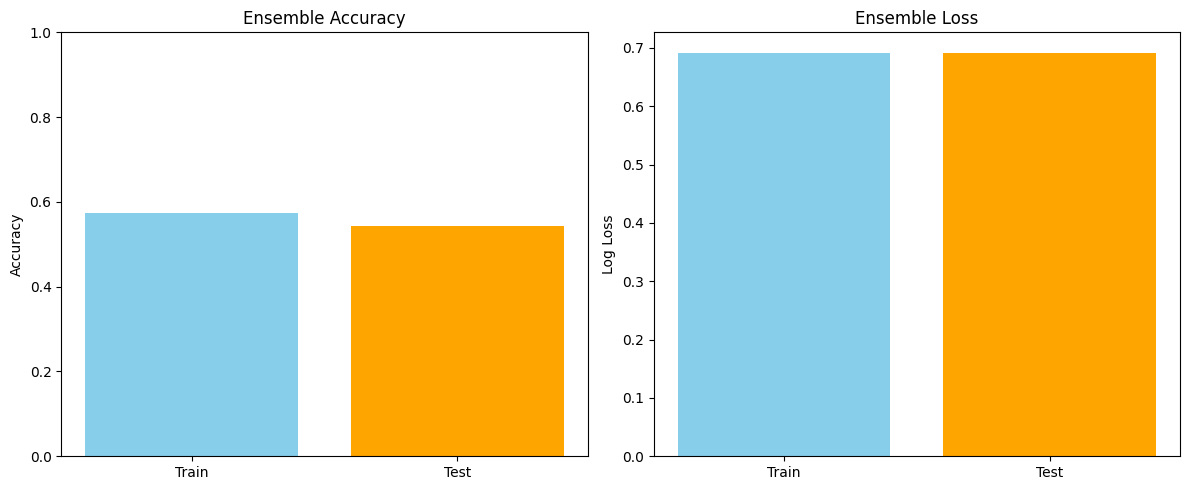

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, log_loss
import torchvision.models as models  # RE-IMPORT if overwritten

# === Get predictions from ensemble ===
def get_all_preds(model_list, loader, device):
    soft_outputs = []
    hard_outputs = []
    y_true = []

    for model in model_list:
        model.eval()
        model.to(device)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float()
            y_true.extend(labels.cpu().numpy())

            probs = []
            for model in model_list:
                output = model(images)
                if isinstance(output, tuple):  # For GoogLeNet
                    output = output[0]
                prob = torch.sigmoid(output).squeeze()
                probs.append(prob.cpu().numpy())

            probs = np.array(probs)
            avg_probs = np.mean(probs, axis=0)
            majority_votes = np.round(np.mean(np.round(probs), axis=0))

            soft_outputs.extend(avg_probs)
            hard_outputs.extend(majority_votes)

    return np.array(y_true), np.array(soft_outputs), np.array(hard_outputs)

# === Compute accuracy and loss ===
def compute_metrics(y_true, y_pred_probs, y_pred_labels):
    acc = accuracy_score(y_true, y_pred_labels)
    loss = log_loss(y_true, y_pred_probs, labels=[0,1])
    return acc, loss

# === Load models freshly here ===
def get_model_resnet():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.fc.in_features, 1))
    return model

def get_model_googlenet():
    model = models.googlenet(pretrained=True, aux_logits=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.fc.in_features, 1))
    return model

def get_model_densenet():
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.classifier.in_features, 1))
    return model

def get_model_mobilenet():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.classifier[1].in_features, 1))
    return model

def get_model_vgg():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[6] = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.classifier[6].in_features, 1))
    return model

def get_model_efficientnet():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.classifier[1].in_features, 1))
    return model

# === Create ensemble ===
ensemble_models = [
    get_model_resnet(),
    get_model_googlenet(),
    get_model_densenet(),
    get_model_mobilenet(),
    get_model_vgg(),
    get_model_efficientnet()
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in ensemble_models:
    model.to(device)

# === Evaluate on Train Set ===
y_true_train, y_soft_train, y_hard_train = get_all_preds(ensemble_models, train_loader, device)
train_acc, train_loss = compute_metrics(y_true_train, y_soft_train, y_hard_train)

# === Evaluate on Test Set ===
y_true_test, y_soft_test, y_hard_test = get_all_preds(ensemble_models, test_loader, device)
test_acc, test_loss = compute_metrics(y_true_test, y_soft_test, y_hard_test)

# === Print all metrics ===
print("\n====== FINAL ENSEMBLE METRICS ======")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Loss:     {train_loss:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Testing Loss:      {test_loss:.4f}")

# === Plot Accuracy and Loss ===
labels = ["Train", "Test"]
accuracies = [train_acc, test_acc]
losses = [train_loss, test_loss]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['skyblue', 'orange'])
plt.title('Ensemble Accuracy')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(labels, losses, color=['skyblue', 'orange'])
plt.title('Ensemble Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_ensemble_metrics(soft_train_acc, soft_train_loss, soft_test_acc, soft_test_loss, hard_test_acc):
    labels = ['Train Acc', 'Train Loss', 'Test Acc', 'Test Loss']
    soft = [soft_train_acc, soft_train_loss, soft_test_acc, soft_test_loss]
    hard = [hard_test_acc, None, hard_test_acc, None]  # Loss not available

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, soft, width, label='Soft Voting')
    ax.bar(x + width/2, [val if val is not None else 0 for val in hard], width, label='Hard Voting', hatch='//')

    ax.set_ylabel('Score')
    ax.set_title('Ensemble Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.ylim([0, 1])
    plt.show()
